In [20]:
import argparse
import pathlib
import random
from collections import deque
from typing import List, Dict, Tuple, Union
from data import Dataset
from data_utils import *
from models import BetaBernoulli
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sampling import *
%matplotlib inline  

import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
LINEWIDTH = 13.97
LOG_FREQ = 10

In [52]:
holdout_ratio = 0.9
prior_strength = 1

class_idx = {s: i for i, s in enumerate(CIFAR100_CLASSES)}
superclass_idx = {s: i for i, s in enumerate(CIFAR100_SUPERCLASSES)}
superclass_lookup = {}
for superclass, class_list in CIFAR100_REVERSE_SUPERCLASS_LOOKUP.items():
    for _class in class_list:
        superclass_lookup[class_idx[_class]] = superclass_idx[superclass]

new_idx = []
for superclass_name in CIFAR100_REVERSE_SUPERCLASS_LOOKUP:
    for class_name in CIFAR100_REVERSE_SUPERCLASS_LOOKUP[superclass_name]:
        new_idx.append(class_idx[class_name])
new_idx = np.array(new_idx)

In [53]:
dataset = Dataset.load_from_text('cifar100')
dataset.group(group_method = 'predicted_class')
dataset.shuffle(0)
train_size = int(dataset.__len__() * (1 - holdout_ratio)) 

train_dataset = Dataset(dataset.labels[:train_size], dataset.scores[:train_size], 'cifar100_train')
train_dataset.group(group_method = 'predicted_class')

eval_dataset = Dataset(dataset.labels[train_size:], dataset.scores[train_size:], 'cifar100_eval')
eval_dataset.group(group_method = 'predicted_class')

In [54]:
matrices = {
    'random_no_prior': train_dataset.confusion_probs(normalize=None),
    'random_uninformative': train_dataset.confusion_probs(normalize=None) + \
                                1.0 / train_dataset.num_groups * prior_strength, 
    'random_informed': train_dataset.confusion_probs(normalize=None) + \
                                train_dataset.confusion_prior * prior_strength,
    'informative_prior': train_dataset.confusion_prior,
    'holdout_no_prior': eval_dataset.confusion_probs(normalize=None),
}

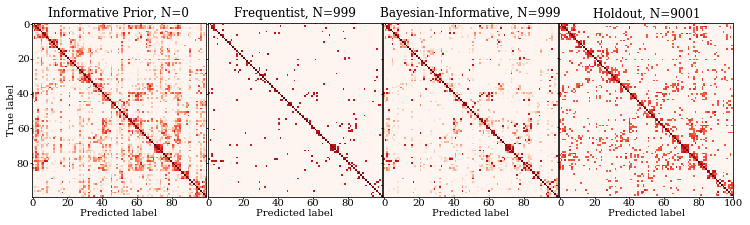

In [55]:
experiment_names = {
                'informative_prior': 'Informative Prior, N=0',
                'random_uniform': 'Random Uninformative', 
                'random_informed': 'Bayesian-Informative, N=%d' % train_size, 
                'random_no_prior': 'Frequentist, N=%d' % train_size,
                'holdout_no_prior': 'Holdout, N=%d' % (dataset.__len__() - train_size)
                }
experiment_list  = [
                    'informative_prior', 
                    'random_no_prior', 
                    'random_informed', 
                    'holdout_no_prior',]


fig, axes = plt.subplots(1, len(experiment_list), sharey=True, sharex=True, figsize=(LINEWIDTH * 0.9, 6.4),
                gridspec_kw = {'wspace':0.01, 'hspace':0.01})

for (i, config) in enumerate(experiment_list):
    matrix = matrices[config][new_idx, :][:, new_idx]
    matrix = matrix / matrix.sum(axis=1)[:, np.newaxis]
    axes[i].imshow(np.log(matrix+ 1e-10).T, vmin=-10, vmax=0, cmap='Reds')
    #axes[i].imshow(matrix.T,cmap='BuGn')
    axes[i].xaxis.set_ticks(np.arange(0, 101, 20))
    axes[i].yaxis.set_ticks(np.arange(0, 101, 20))
    axes[0].set_ylabel("True label", labelpad=0.5)
    axes[i].set_xlabel("Predicted label", labelpad=0.5)
    axes[i].tick_params(pad=0.2, length=2)
    axes[i].set_title(experiment_names[config])

fig.tight_layout()
fig.savefig('../figures/confusion_illustrative.pdf', dpi=300, bbox_inches='tight', pad_inches=0)   

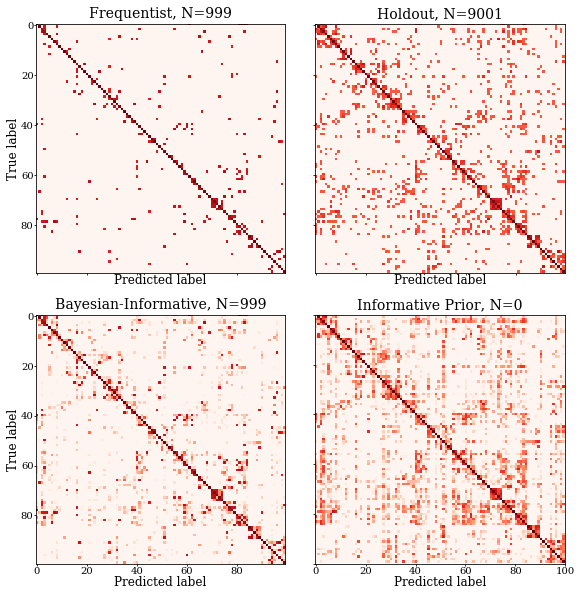

In [56]:
experiment_list  = ['random_no_prior', 
                    'holdout_no_prior',
                    'random_informed', 
                    'informative_prior', ]
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(LINEWIDTH * 0.6, LINEWIDTH * 0.6))
for (i, config) in enumerate(experiment_list):
    matrix = matrices[config][new_idx, :][:, new_idx]
    matrix = matrix / matrix.sum(axis=1)[:, np.newaxis]
    axes[i//2, i%2].imshow(np.log(matrix+ 1e-10).T, vmin=-10, vmax=0, cmap='Reds')
    axes[i//2, i%2].xaxis.set_ticks(np.arange(0, 101, 20))
    axes[i//2, i%2].yaxis.set_ticks(np.arange(0, 101, 20))
    axes[i//2, i%2].set_xlabel("Predicted label", labelpad=0.5, fontsize=12)
    axes[i//2, i%2].tick_params(pad=0.2, length=2)
    axes[i//2, i%2].set_title(experiment_names[config], fontsize=14)
    axes[i//2, 0].set_ylabel("True label", labelpad=0.5, fontsize=12)

fig.tight_layout()
fig.savefig('../figures/confusion_illustrative.pdf', dpi=300, bbox_inches='tight', pad_inches=0)   

In [1]:
# cmaps = [('Perceptually Uniform Sequential', [
#             'viridis', 'plasma', 'inferno', 'magma', 'cividis']),
#          ('Sequential', [
#             'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
#             'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
#             'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
#          ('Sequential (2)', [
#             'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
#             'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
#             'hot', 'afmhot', 'gist_heat', 'copper']),
#          ('Diverging', [
#             'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
#             'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
#          ('Cyclic', ['twilight', 'twilight_shifted', 'hsv']),
#          ('Qualitative', [
#             'Pastel1', 'Pastel2', 'Paired', 'Accent',
#             'Dark2', 'Set1', 'Set2', 'Set3',
#             'tab10', 'tab20', 'tab20b', 'tab20c']),
#          ('Miscellaneous', [
#             'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
#             'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
#             'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])]

# for i in range(len(cmaps)):
#     for cmap in cmaps[i][1]:
#         fig, axes = plt.subplots(1, len(experiment_list), sharey=True, sharex=True, figsize=(LINEWIDTH * 0.9, 6.4),
#                 gridspec_kw = {'wspace':0.01, 'hspace':0.01})

#         for (i, config) in enumerate(experiment_list):
#             matrix = matrices[config][new_idx, :][:, new_idx]
#             matrix = matrix / matrix.sum(axis=1)[:, np.newaxis]
#             axes[i].imshow(np.log(matrix + 1e-10).T, vmin=-10, vmax=0, cmap=cmap)
#             #axes[i].imshow(matrix.T,cmap='BuGn')
#             axes[i].xaxis.set_ticks(np.arange(0, 101, 20))
#             axes[i].yaxis.set_ticks(np.arange(0, 101, 20))
#             axes[0].set_ylabel("True label, cmap=%s" % cmap, labelpad=0.5)
#             axes[i].set_xlabel("Predicted label", labelpad=0.5)
#             axes[i].tick_params(pad=0.2, length=2)
#             axes[i].set_title(experiment_names[config])

#         fig.tight_layout()